# EDA
* 안과 질환 인식을 위한 탐색적 데이터 분석 데이터 세트.
* 환자를 다음과 같은 8개의 라벨로 분류한다.

including:
* Normal (N) 정상
* Diabetes (D) 당뇨병 
* Glaucoma (G) 녹내장
* Cataract (C) 백내장
* AMD (A) AMD
* Hypertension (H) 고혈압
* Myopia (M) 근시
* Other diseases/abnormalities (O)  기타 질병/이상

# Data preparation


## Load packages

In [1]:
!pip install wordcloud

In [4]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Word cloud 는 중요한 단어나 키워드를 직관적으로 보여주는 시각화 도구 
from wordcloud import WordCloud, STOPWORDS

## Explore data sources

In [5]:
pwd

'D:\\Python\\2. 프로젝트\\안저녹내장'

In [6]:
print(os.listdir("./rawdata/archive/ODIR-5K/ODIR-5K"))

['data.xlsx', 'Testing Images', 'Training Images']



## Load Dataset (Excel)

In [7]:
data_df = pd.read_excel(open("./rawdata/archive/ODIR-5K/ODIR-5K/data.xlsx", 'rb'), sheet_name='Sheet1')
data_df.head()

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   3           66        Male  3_left.jpg  3_right.jpg   
4   4           53        Male  4_left.jpg  4_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                                      normal fundus   
4                        macular epiretinal membrane   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  
0                           normal fundus  0  0  0  1  0  0  0  0  
1                           normal fundus  1  0  0  0  0  0  0  0  
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1  
3         branch retinal artery occlusion  0  0  0  0  0  0  0  1  
4       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1

* columns 명 쉽게 변경

In [8]:
data_df.columns = ["id", 'age', "sex", "left_fundus", "right_fundus", "left_diagnosys", "right_diagnosys", "normal",
                  "diabetes", "glaucoma", "cataract", "amd", "hypertension", "myopia", "other"]
data_df.head()

id  age     sex left_fundus right_fundus  \
0   0   69  Female  0_left.jpg  0_right.jpg   
1   1   57    Male  1_left.jpg  1_right.jpg   
2   2   42    Male  2_left.jpg  2_right.jpg   
3   3   66    Male  3_left.jpg  3_right.jpg   
4   4   53    Male  4_left.jpg  4_right.jpg   

                                      left_diagnosys  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                                      normal fundus   
4                        macular epiretinal membrane   

                          right_diagnosys  normal  diabetes  glaucoma  \
0                           normal fundus       0         0         0   
1                           normal fundus       1         0         0   
2  moderate non proliferative retinopathy       0         1         0   
3         branch retinal artery occlusion       0         0         0   
4       mild nonproliferative retinopathy       0         1         0   

   cataract  amd  hypertension  myopia  other  
0         1    0             0       0      0  
1         0    0             0       0      0  
2         0    0             0       0      1  
3         0    0             0       0      1  
4         0    0             0       0      1

In [9]:
print(f"data shape: {data_df.shape}")
print(f"left fundus: {data_df.left_fundus.nunique()}")
print(f"right fundus: {data_df.right_fundus.nunique()}")

data shape: (3500, 15)
left fundus: 3500
right fundus: 3500


# Data 탐색

## Check tabelar data

7000개의 이미지와 왼쪽 눈과 오른쪽 눈의 각각의 이미지를 가지고 있다.
왼쪽 - 3500
오른쪽 - 3500

## Check image data


We check now the image data for completeness.

In [10]:
print(f"train images: {len(os.listdir('./rawdata/archive/ODIR-5K/ODIR-5K/Training Images'))}")
print(f"test images: {len(os.listdir('./rawdata/archive/ODIR-5K/ODIR-5K/Testing Images'))}")
print(f"train images - left eye: {len(glob.glob('./rawdata/archive/ODIR-5K/ODIR-5K/Training Images/*_left.jpg'))}")
print(f"train images - right eye: {len(glob.glob('./rawdata/archive/ODIR-5K/ODIR-5K/Training Images/*_right.jpg'))}")
print(f"test images - left eye: {len(glob.glob('./rawdata/archive/ODIR-5K/ODIR-5K/Testing Images/*_left.jpg'))}")
print(f"test images - right eye: {len(glob.glob('./rawdata/archive/ODIR-5K/ODIR-5K/Testing Images/*_right.jpg'))}")

train images: 7000
test images: 1000
train images - left eye: 3500
train images - right eye: 3500
test images - left eye: 500
test images - right eye: 500


트레이닝 세트에는 7000개의 이미지가 있고 테스트 세트에는 1000개의 이미지가 있으며, 그 중 절반은 왼쪽 눈, 절반은 오른쪽 눈이다.

각 질병마다 라벨은 하나뿐이고 환자마다 양쪽 눈에 대한 기록이 같기 때문에 오른쪽 진단에서 각각 왼쪽 진단에서 어떤 눈이 라벨을 지칭하는지 유추해야 할 것이다.
(Since there is only one flag for each patology, and we have same record for both eyes for each patient, we will need to infer from the left diagnosys, respectively from right diagnosis, to which eye reffers the flag)

예를 들어 ID가 '0'(여, 69세)인 환자의 경우 **백내장**을 나타내는 라벨 '1'이 있습니다. **left_diagnostics* 및 **right_diagnostics**를 보면, 왼쪽_diagnostics에 대해서만 백내장이 표시되어 있습니다. 따라서 백내장을 인식하는 모델을 훈련하려면 왼쪽 눈(이미지 '0_left.png')에 **cataract** 플래그 1과 함께 있는 것으로만 레이블을 붙인다.

## Data 분포

In [31]:
# 범주형 변수의 빈도수를 카운트 countplot
def plot_count(feature, title, df, size=1, show_all=False):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    if show_all:
        g = sns.countplot(df[feature], palette='Set3')
        g.set_title("{} 분산".format(title))
    else:
        g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
        if(size > 2):
            plt.xticks(rotation=90, size=8)
            for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 0.2,
                        '{:1.2f}%'.format(100*height/total),
                        ha="center") 
        g.set_title("{} 샘플 수 및 백분률".format(title))
    plt.rc("font", family = "Malgun Gothic")
    plt.show()    

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


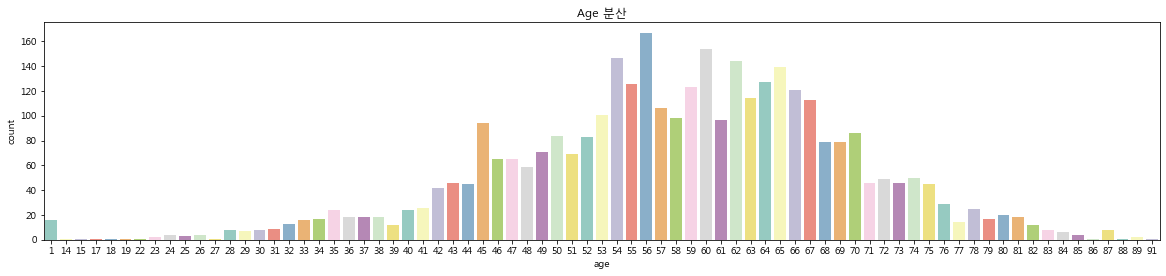

In [32]:
plot_count("age", "Age", data_df, size=5, show_all=True)
# plot without specifying the x, y parameters

In [33]:
# plot without specifying the x, y parameters
sns.regplot(x,y)

NameError: name 'x' is not defined

## 질환별 발생률

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


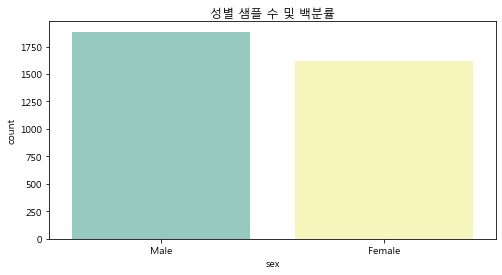

In [34]:
plot_count("sex", "성별", data_df, size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


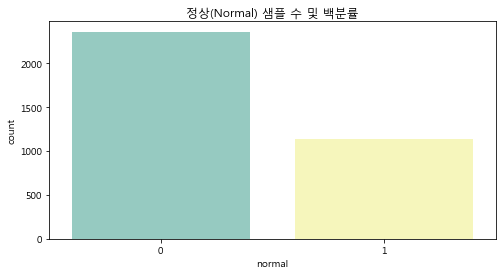

In [35]:
#정상
plot_count("normal", "정상(Normal)", data_df, size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


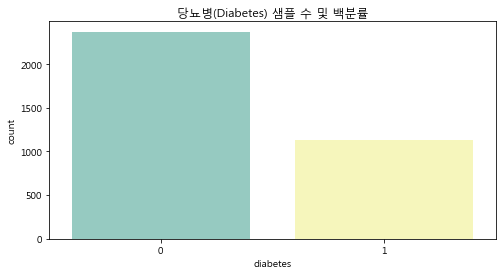

In [36]:
# 당뇨병
plot_count("diabetes", "당뇨병(Diabetes)", data_df, size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


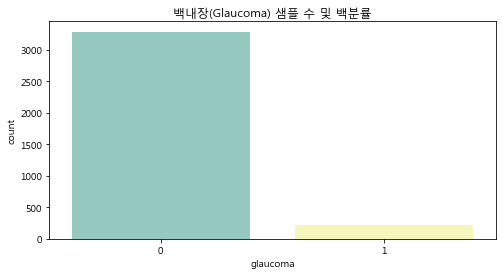

In [38]:
# 백내장
plot_count("glaucoma", "백내장(Glaucoma)", data_df, size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


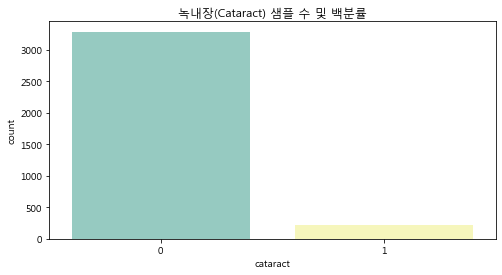

In [40]:
#녹내장
plot_count("cataract", "녹내장(Cataract)", data_df, size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


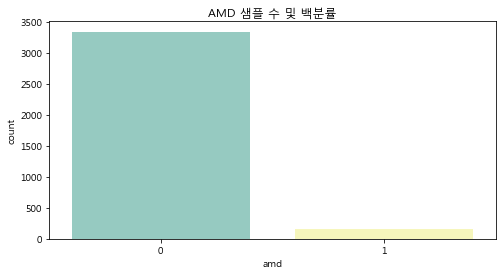

In [41]:
# AMD
plot_count("amd", "AMD", data_df, size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


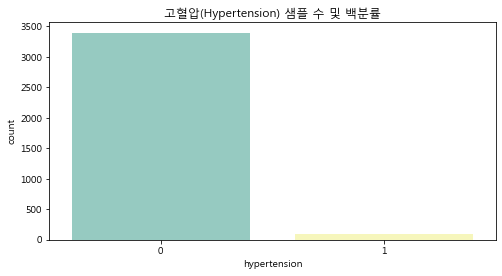

In [43]:
# 고혈압
plot_count("hypertension", "고혈압(Hypertension)", data_df, size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


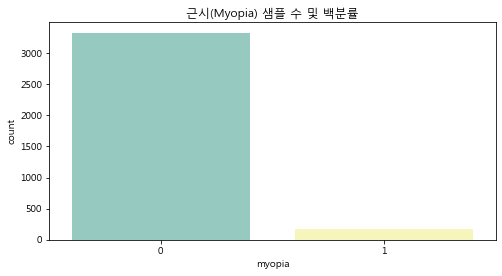

In [44]:
# 근시
plot_count("myopia", "근시(Myopia)", data_df, size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


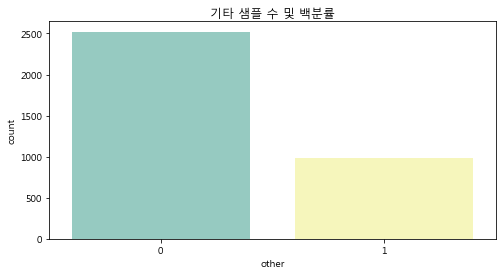

In [54]:
plot_count("other", "기타", data_df, size=2)

## 좌우 눈에 대한 코멘트 분포

Let's verify now the distribution of comments associated with the left and right eye.
* 이제 왼쪽 눈과 오른쪽 눈과 관련된 코멘트의 분포를 확인하겠습니다.

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


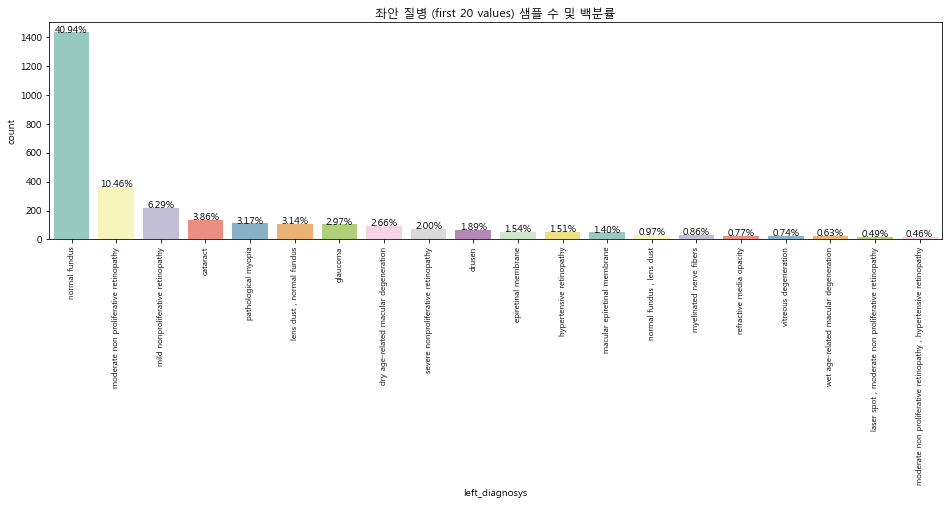

In [52]:
plot_count("left_diagnosys", "좌안 질병 (first 20 values)", data_df, size=4)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


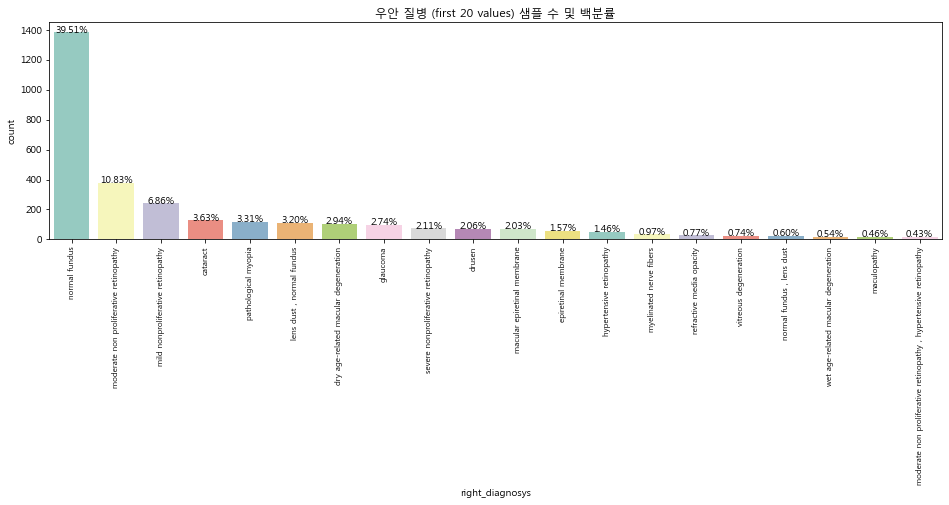

In [53]:
plot_count("right_diagnosys", "우안 질병 (first 20 values)", data_df, size=4)

Let's check now frequence of words used in diagnosys for left and right eye, as a wordcloud, to see what are the most frequent words used in such diagnosys.

In [49]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=40,
        max_font_size=40, 
        scale=3,
        random_state=1,
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

### 코멘트 워드클라우드

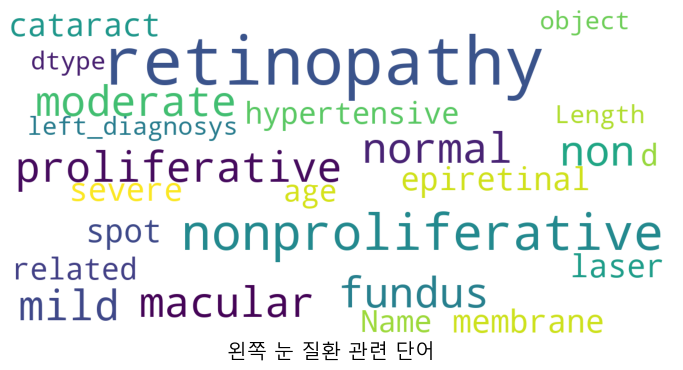

In [55]:
show_wordcloud(data_df['left_diagnosys'], title = '왼쪽 눈 질환 관련 단어')

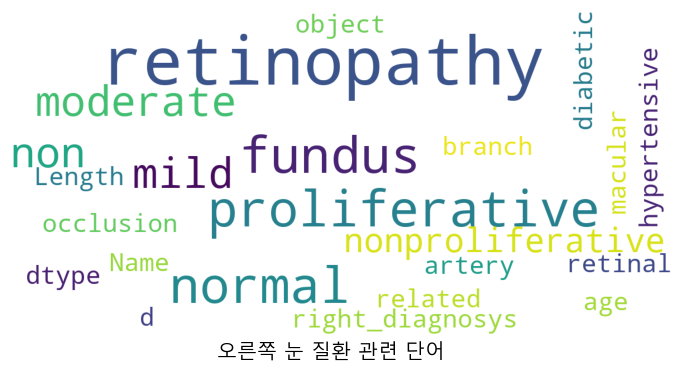

In [56]:
show_wordcloud(data_df['right_diagnosys'], title = '오른쪽 눈 질환 관련 단어')

We can observe that the words used in diagnosys are quite balanced from the point of view of the two eyes.  


Let's look now to people with cataract and check what are the associated texts for left and right diagnosys,

우리는 진단에 사용되는 단어들이 두 눈의 관점에서 상당히 균형잡힌 것을 관찰할 수 있다.

이제 백내장이 있는 사람들을 보고 좌우 진단에 관련된 문자들이 무엇인지 살펴봅시다.


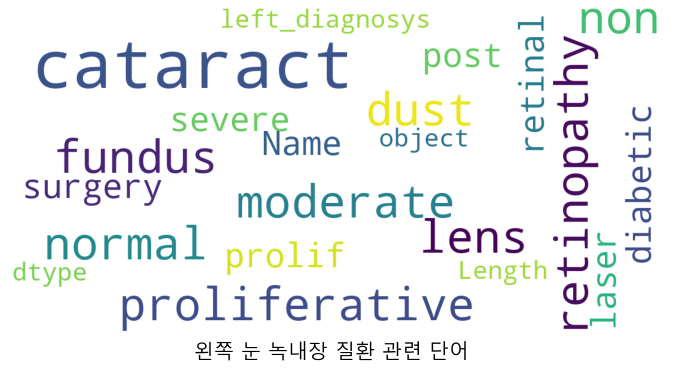

In [57]:
cataract_df = data_df.loc[data_df.cataract == 1]
show_wordcloud(cataract_df['left_diagnosys'], title = '왼쪽 눈 녹내장 질환 관련 단어')

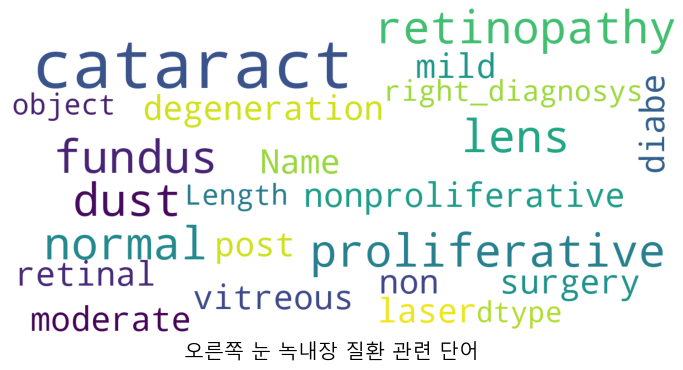

In [58]:
show_wordcloud(cataract_df['right_diagnosys'], title = '오른쪽 눈 녹내장 질환 관련 단어')

## 성별에 따른 안과 질환 발생률

In [ ]:
def plot_feature_distribution_grouped(feature, title, df, hue, size=4):
    plt.figure(figsize=(size*5,size*2))
    plt.title(title)
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    g = sns.countplot(df[feature], hue=df[hue], palette='Set3')
    plt.xlabel(feature)
    plt.legend()
    plt.show()

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


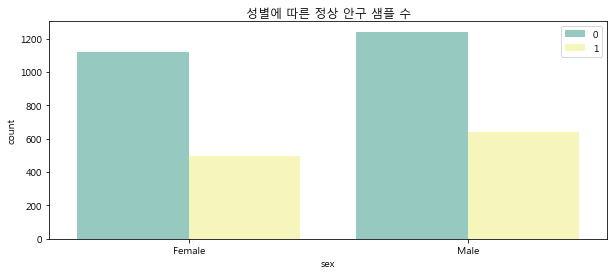

In [ ]:
plot_feature_distribution_grouped('sex', '성별에 따른 정상 안구 샘플 수', data_df, 'normal', size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


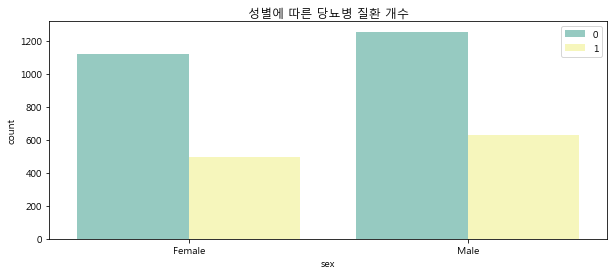

In [ ]:
plot_feature_distribution_grouped('sex', '성별에 따른 당뇨병 질환 개수', data_df, 'diabetes', size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


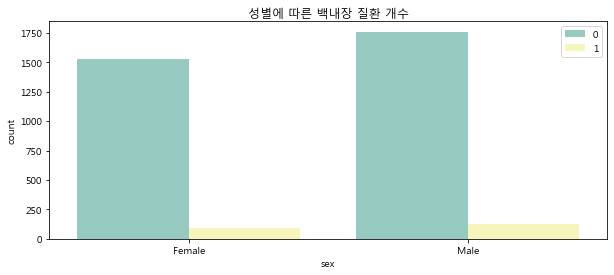

In [ ]:
plot_feature_distribution_grouped('sex', '성별에 따른 백내장 질환 개수', data_df, 'glaucoma', size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


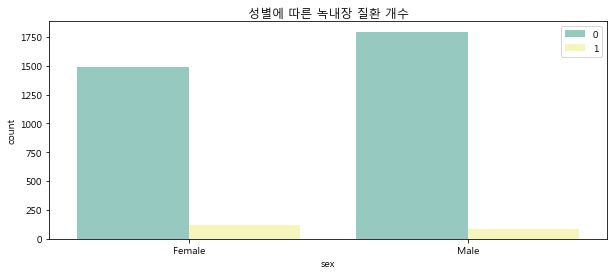

In [ ]:
plot_feature_distribution_grouped('sex', '성별에 따른 녹내장 질환 개수', data_df, 'cataract', size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


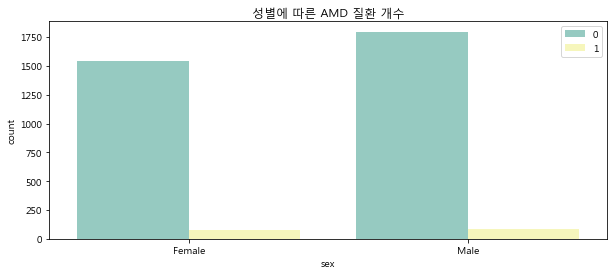

In [ ]:
plot_feature_distribution_grouped('sex', '성별에 따른 AMD 질환 개수', data_df, 'amd', size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


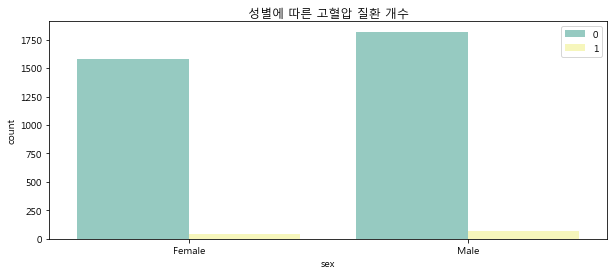

In [ ]:
plot_feature_distribution_grouped('sex', '성별에 따른 고혈압 질환 개수', data_df, 'hypertension', size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


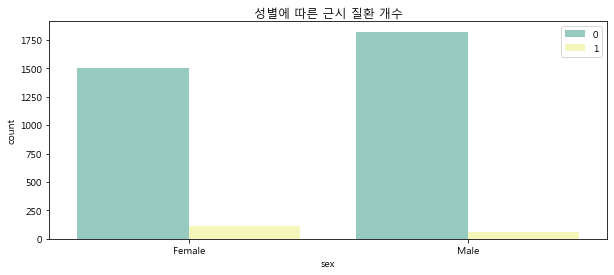

In [ ]:
plot_feature_distribution_grouped('sex', '성별에 따른 근시 질환 개수', data_df, 'myopia', size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


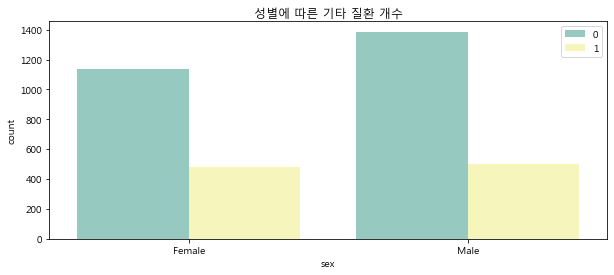

In [ ]:
plot_feature_distribution_grouped('sex', '성별에 따른 기타 질환 개수', data_df, 'other', size=2)

## 나이대별 안구 질환 발생률

In [76]:
#나이대 칼럼 추가
def age_categorize(age):
    age = (age //10)*10
    return age

age_category = (data_df['age'].apply(age_categorize)).astype('category')
data_df.insert(2, 'age_category', age_category)
data_df.head()


ValueError: cannot insert age_category, already exists

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


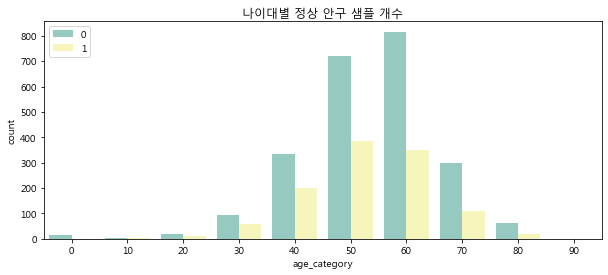

In [80]:
plot_feature_distribution_grouped('age_category', '나이대별 정상 안구 샘플 개수', data_df, 'normal', size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


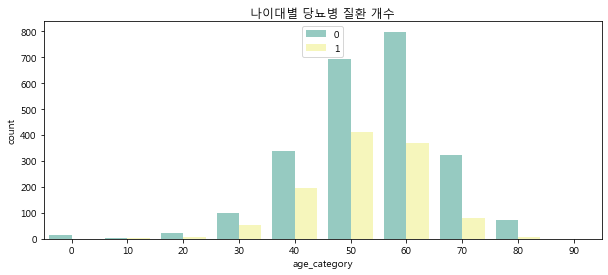

In [81]:
plot_feature_distribution_grouped('age_category', '나이대별 당뇨병 질환 개수', data_df, 'diabetes', size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


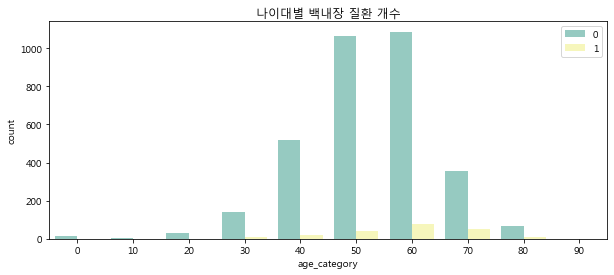

In [82]:
plot_feature_distribution_grouped('age_category', '나이대별 백내장 질환 개수', data_df, 'glaucoma', size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


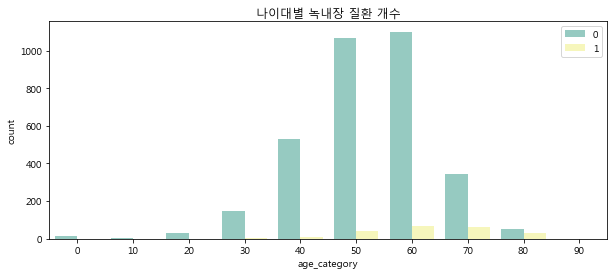

In [83]:
plot_feature_distribution_grouped('age_category', '나이대별 녹내장 질환 개수', data_df, 'cataract', size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


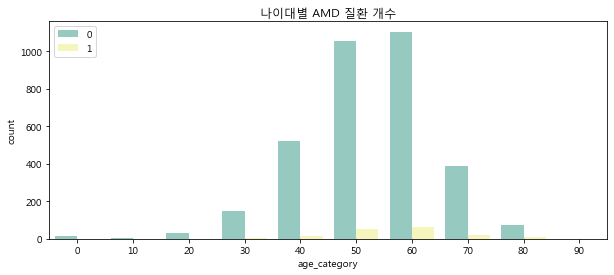

In [84]:
plot_feature_distribution_grouped('age_category', '나이대별 AMD 질환 개수', data_df, 'amd', size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


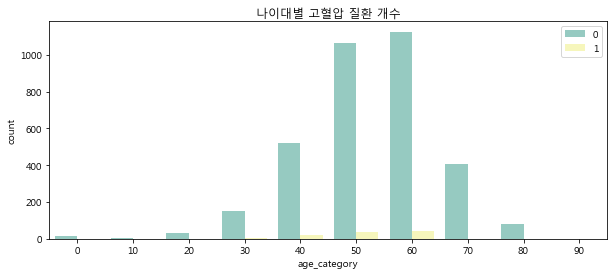

In [85]:
plot_feature_distribution_grouped('age_category', '나이대별 고혈압 질환 개수', data_df, 'hypertension', size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


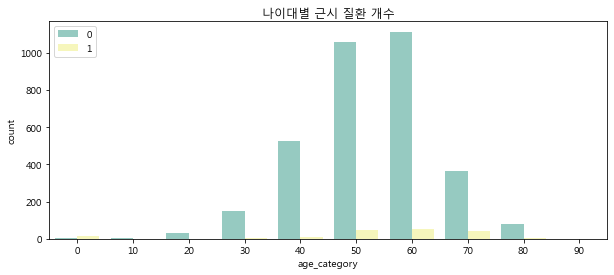

In [86]:
plot_feature_distribution_grouped('age_category', '나이대별 근시 질환 개수', data_df, 'myopia', size=2)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


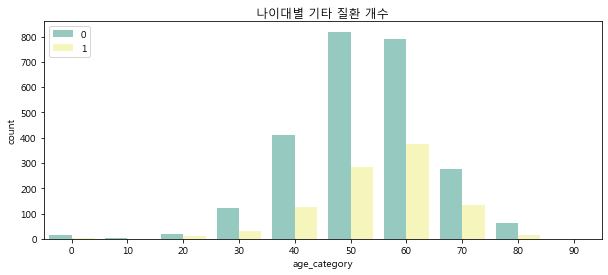

In [87]:
plot_feature_distribution_grouped('age_category', '나이대별 기타 질환 개수', data_df, 'other', size=2)

# 안저 이미지 확인

Let's inspect the images.

In [69]:
import imageio
IMAGE_PATH = "./rawdata/archive/ODIR-5K/ODIR-5K/Training Images"
def show_images(df, title="Diagnosys", eye_exam="left_fundus"):
    print(f"{title}; eye exam: {eye_exam}")
    f, ax = plt.subplots(3,3, figsize=(16,16))
    for i,idx in enumerate(df.index):
        dd = df.iloc[idx]
        image_name = dd[eye_exam]
        image_path = os.path.join(IMAGE_PATH, image_name)
        img_data=imageio.imread(image_path)
        ax[i//3, i%3].imshow(img_data)
        ax[i//3, i%3].axis('off')
    plt.show()

## 좌우 당뇨병

In [88]:
df = data_df.loc[(data_df.cataract==1) & (data_df.left_diagnosys=="diabetes")].sample(9).reset_index()
show_images(df,title="Left eye with cataract",eye_exam="left_fundus")

df = data_df.loc[(data_df.cataract==1) & (data_df.right_diagnosys=="diabetes")].sample(9).reset_index()
show_images(df,title="Right eye with cataract",eye_exam="right_fundus")

ValueError: a must be greater than 0 unless no samples are taken

### Left-eye and right-eye cataract
## 좌우 백내장

Left eye with cataract; eye exam: left_fundus


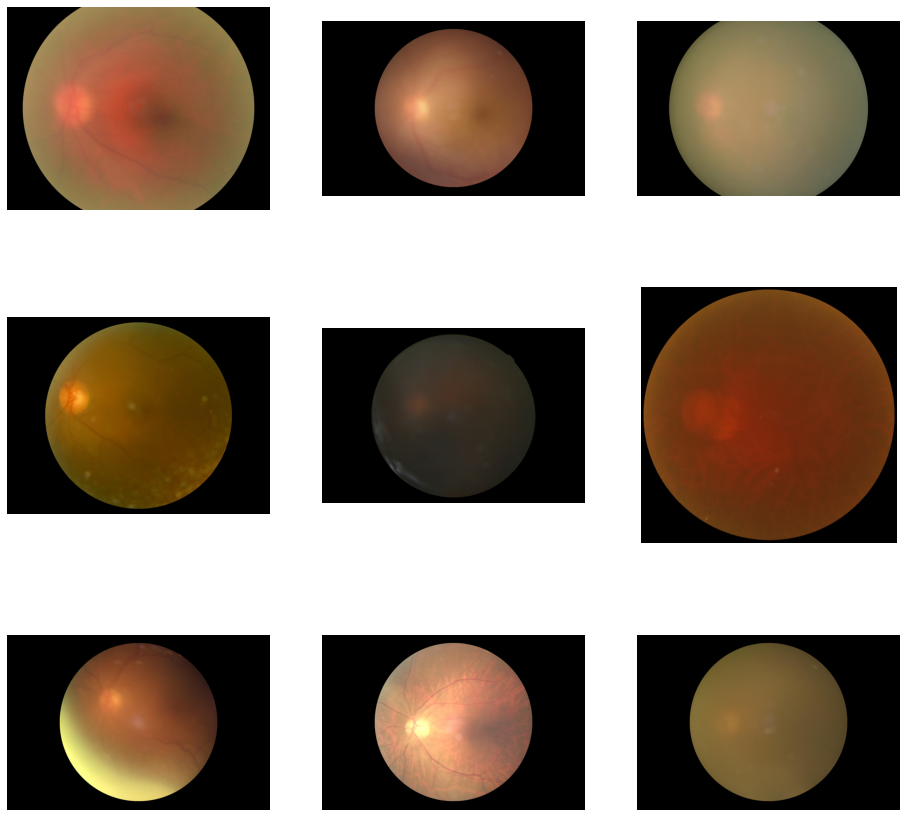

In [70]:
df = data_df.loc[(data_df.cataract==1) & (data_df.left_diagnosys=="cataract")].sample(9).reset_index()
show_images(df,title="Left eye with cataract",eye_exam="left_fundus")

Right eye with cataract; eye exam: right_fundus


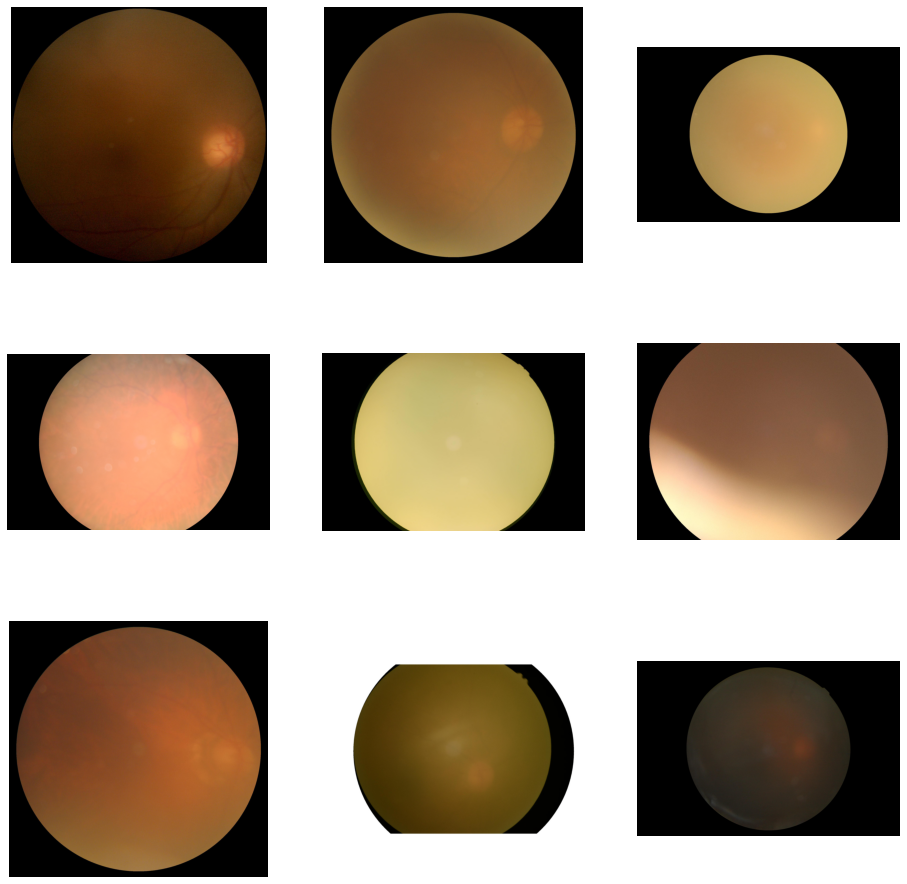

In [39]:
df = data_df.loc[(data_df.cataract==1) & (data_df.right_diagnosys=="cataract")].sample(9).reset_index()
show_images(df,title="Right eye with cataract",eye_exam="right_fundus")

### Left-eye and right-eye glaucom
## 좌 우 녹내장

Left eye with glaucoma; eye exam: left_fundus


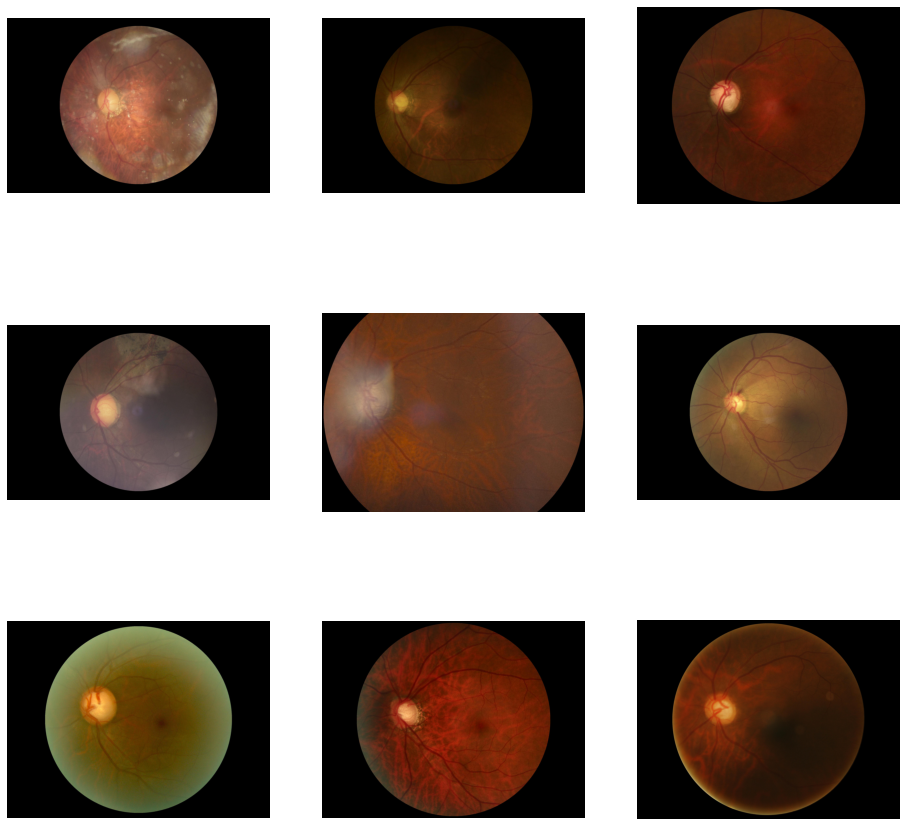

In [71]:
df = data_df.loc[(data_df.glaucoma==1) & (data_df.left_diagnosys=="glaucoma")].sample(9).reset_index()
show_images(df,title="Left eye with glaucoma",eye_exam="left_fundus")

Right eye with glaucoma; eye exam: right_fundus


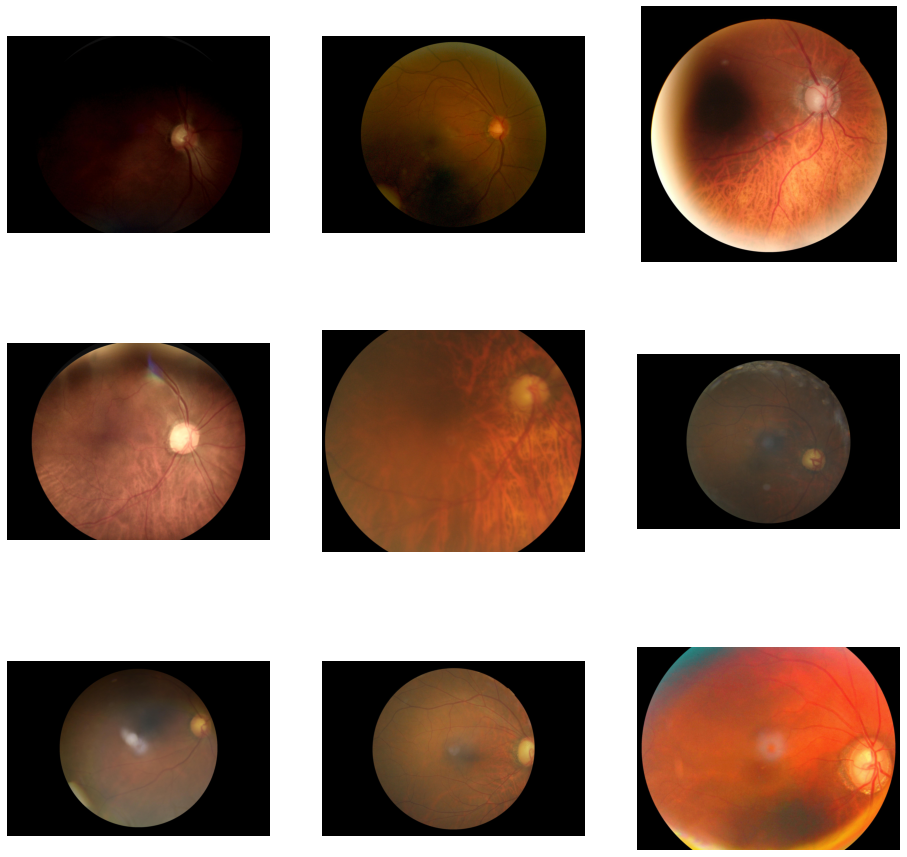

In [72]:
df = data_df.loc[(data_df.glaucoma==1) & (data_df.right_diagnosys=="glaucoma")].sample(9).reset_index()
show_images(df,title="Right eye with glaucoma",eye_exam="right_fundus")

### Left-eye and right-eye myopia
### 좌 우 근시

Left eye with myopia; eye exam: left_fundus


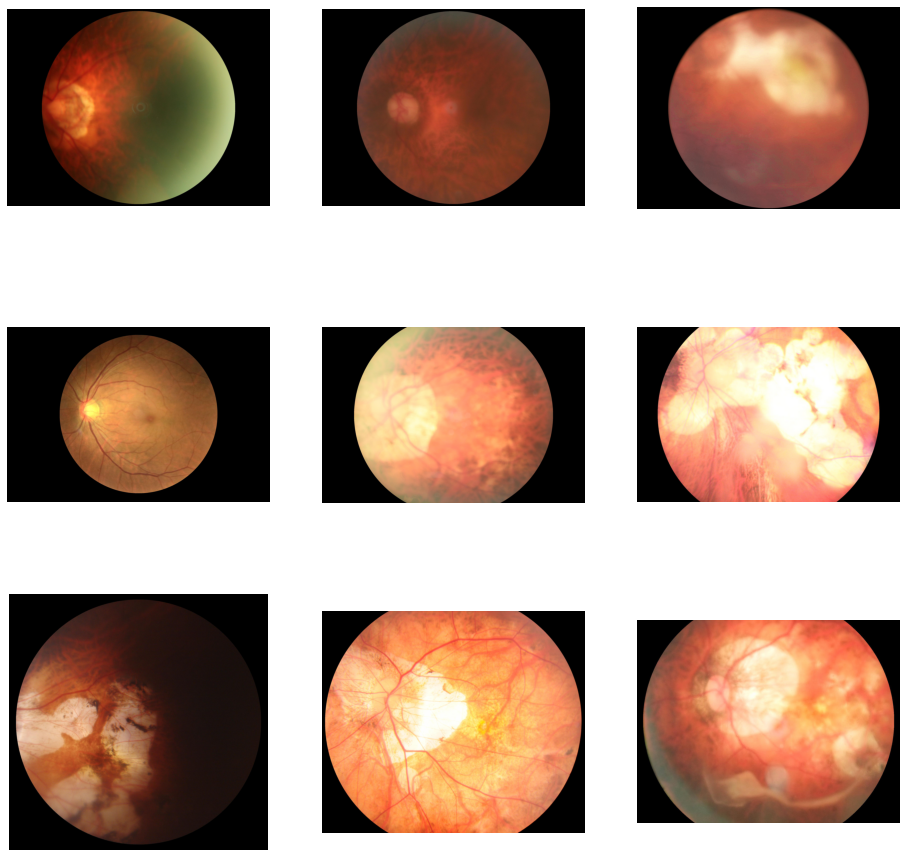

In [73]:
df = data_df.loc[(data_df.myopia==1)].sample(9).reset_index()
show_images(df,title="Left eye with myopia",eye_exam="left_fundus")

Right eye with myopia; eye exam: right_fundus


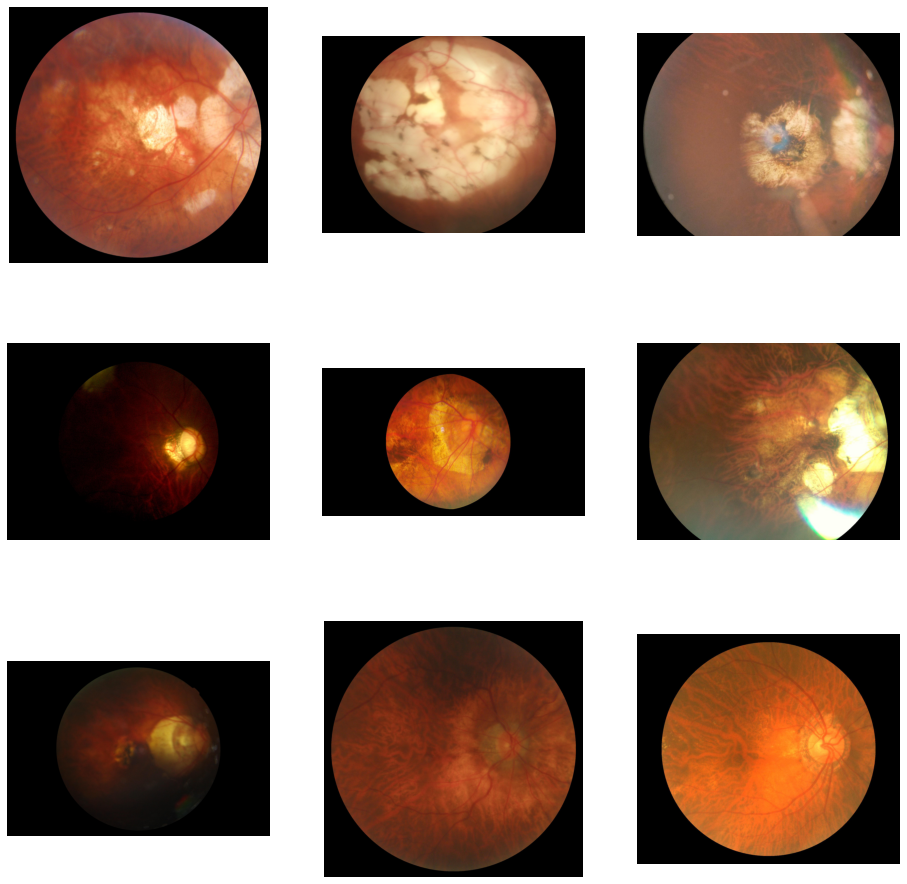

In [74]:
df = data_df.loc[(data_df.myopia==1)].sample(9).reset_index()
show_images(df,title="Right eye with myopia",eye_exam="right_fundus")

## 좌우 다른 병명도 그림으로 찾아보기